In [1]:
import os

import numpy as np
import scipy as sc
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator

torch.manual_seed(17)

# Extract and list files in dataset
Dataset is stored in an archives so it can be uploaded to github.
The archive is created in the data/fashionMNIST directory which is created if it does not exists.

The notebook also create directories in which save figures and models.

In [2]:
!mkdir -p ../data
!mkdir -p ../figures
!mkdir -p ../models

# Read dataset

Read the dataset from the data/fashionMNIST directory

In [3]:
# Useful constants
img_shape = (28,28)
batch_size = 128
n_classes = 10

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

train_set = torchvision.datasets.FashionMNIST(root="../data/", train=True, download=True, transform=transform)
train_set_size = len(train_set)

test_set = torchvision.datasets.FashionMNIST(root="../data/", train=False, download=True, transform=transform)
test_set_size = len(test_set)

n_batches_train = np.ceil(train_set_size/batch_size)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    
n_batches_test = np.ceil(test_set_size/batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [5]:
labels_name = {0: "Top",
               1: "Trouser",
               2: "Pullover",
               3: "Dress",
               4: "Coat",
               5: "Sandal",
               6: "Shirt",
               7: "Sneaker",
               8: "Bag",
               9: "Ankle boot"}

# Helper functions

Here are the implementation of some usefull functions

In [6]:
def showimg(img, ax=None, shape=(28, 28), cmap='plasma', title="", fontsize=15, axis=False, savefig=True, savedir=None):
    if ax is None: _, ax = plt.subplots()
    if not axis: ax.axis('off')
        
    img = img.reshape(shape)
    ax.imshow(img, cmap=cmap)
    ax.set_title(title, fontsize=fontsize)
    
    if savefig and filename is not None: plt.savefig(f"{filename}{savedir}.png")

In [7]:
def showimgpanel(imgs, n_imgs, panelshape, figsize=(15,15), 
                 labels=None, labels_prefix="Label : ",
                 title="", fontsize_title=30, fontsize_label=15, 
                 savefig=True, savedir=None):
    x,y = panelshape
    n_imgs = min(imgs.shape[0], n_imgs, x*y)
    
    fig = plt.figure(figsize = figsize)
    fig.suptitle(title, fontsize = fontsize_title)
    fig.subplots_adjust(wspace=0.1, hspace=0.2)
    
    for i in range(n_imgs):
        ax = fig.add_subplot(x, y, i+1)
        img = imgs[i]
        
        if labels is None: label = ''
        else: label = labels_prefix + str(int(labels[i]))
        
        showimg(img, ax, title=label, fontsize=fontsize_label, savefig=False)            
        
    if savefig and filename is not None: plt.savefig(f"{savedir}{title}.png")
    

In [8]:
# Divide dataset into batches

def divideInBatches(train_set, test_set, batch_size, n_train_set, n_test_set):
    # Train set
    n_batches_total = math.ceil(n_train_set/batch_size)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    
    # Test set
    n_batches_total_test = math.ceil(n_test_set/batch_size)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)
    
    return train_loader, test_loader, n_batches_total, n_batches_total_test

In [9]:
# Check if GPU is available

def chooseDevice():
    device = ""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU available via cuda")
    else:
        device = torch.device("cpu")
        print("GPU not available, CPU available")
    return device

In [10]:
def numberParameters(model, trainable = False, model_name = None):
    total_params = sum(param.numel() for param in model.parameters())
    if model_name != None:
        print("Number of parameters of " + model_name + ": " + str(total_params))
    return total_params

In [11]:
device = chooseDevice()

GPU available via cuda


# Model definition
Here we will define the architecture of our models

In [12]:
# PARALETERS
dim_latent_space = 100
n_epoch_gan = 5


## Generator model

In [13]:
class Generator(nn.Module):

    def __init__(self, dim_latent_space):
        super().__init__()
        self.dim_latent_space = dim_latent_space
        self.fc = nn.Linear(self.dim_latent_space, 64*7*7)
        self.trans_conv1 = nn.ConvTranspose2d(64, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.trans_conv2 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.trans_conv3 = nn.ConvTranspose2d(32, 16, kernel_size = 3, stride = 1, padding = 1)
        self.batch_norm3 = nn.BatchNorm2d(16)
        self.trans_conv4 = nn.ConvTranspose2d(16, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        
    def forward(self, x):                   # Input = batch_size*dim_latent_space
        x = self.fc(x)                      # Output = batch_size*(64*7*7)
        x = x.view(-1, 64, 7, 7)            # Output = batch_size*64*7*7
        x = self.trans_conv1(x)             # Output = batch_size*64*14*14
        x = F.relu(self.batch_norm1(x))
        x = self.trans_conv2(x)             # Output = batch_size*32*14*14
        x = F.relu(self.batch_norm2(x))
        x = self.trans_conv3(x)             # Output = batch_size*16*14*14
        x = F.relu(self.batch_norm3(x))     
        x = self.trans_conv4(x)             # Output = batch_size*1*28*28
        x = torch.tanh(x)
        return x

In [14]:
generators = {}
for (i, key) in labels_name.items():
    generator = Generator(dim_latent_space)
    generators[i] = generator
    generators[key] = generator
    del generator

## Discriminator model

In [15]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1)     
        self.conv0_drop = nn.Dropout2d(0.25)
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_drop = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_drop = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(128, 128, kernel_size = 3, stride = 2, padding = 1)
        self.conv3_drop = nn.Dropout2d(0.25)
        self.fc = nn.Linear(128*7*7, 1)
    
    def forward(self, x):                               # Input = batch_size*1*28*28
        x = x.view(-1, 1, 28, 28)                       # Output = batch_size*1*28*28
        x = F.leaky_relu(self.conv0(x), 0.2)            # Output = batch_size*32*14*14
        x = self.conv0_drop(x)
        x = F.leaky_relu(self.conv1(x), 0.2)            # Output = batch_size*64*14*14
        x = self.conv1_drop(x)
        x = F.leaky_relu(self.conv2(x), 0.2)            # Output = batch_size*128*14*14
        x = self.conv2_drop(x)
        x = F.leaky_relu(self.conv3(x), 0.2)            # Output = batch_size*128*7*7
        x = self.conv3_drop(x)
        x = x.view(-1, 128*7*7)                         # Output = batch_size*(128*7*7)
        x = self.fc(x)                                  # Output = batch_size*1
        return x

In [16]:
discriminators = {}
for (i, key) in labels_name.items():
    discriminator = Discriminator()
    generators[i] = discriminator
    generators[key] = discriminator
    del discriminator

## CNN model

In [17]:
class CNN(nn.Module):
    def __init__(self, n_classes):
        super(CNN, self).__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Sequential(             # Images input is batch_size*1*28*28
            nn.Conv2d(1, 16, 5, 1, 2),          # Output is batch_size*16*28*28
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),        # Output is batch_size*16*14*14
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),         # Output is batch_size*32*14*14
            nn.ReLU(),                      
            nn.MaxPool2d(2),                    # Output is batch_size*32*7*7
        )
        # fully connected layer, output one number for each class
        self.out = nn.Sequential(         
            nn.Linear(32 * 7 * 7, self.n_classes),          # Output is batch_size*n_classes
        )
    
    def scaleToProbabilities(self, outmap, scale_factor = 3): 
        # scale_factor allows to scale your output before passing it into the softmax function 
        # in order to get numbers interpratble as probabilities
        
        flattened_outmap = outmap.view(outmap.shape[0], -1)
        outmap_std = torch.std(flattened_outmap, dim = 1).view(-1, 1)
        outmap_scaled_std = torch.div(outmap, outmap_std)
        probabilities = nn.functional.softmax(outmap_scaled_std*scale_factor, dim=1)
        return probabilities
    
    def predictLabels(self, outmap, scale_factor = 3):
        probabilities = self.scaleToProbabilities(outmap, scale_factor = 3)
        certainty, predicted_labels = torch.max(probabilities, 1)
        predicted_labels = predicted_labels.data.squeeze()
        certainty = certainty.data.squeeze()
        return predicted_labels, probabilities, certainty
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), 32 * 7 * 7)
        output = self.out(x)
        return output

# Training

## Train CNN on full data set

In [18]:
cnn_full = CNN(n_classes).to(device=device)

In [19]:
# Loss function for the CNN
loss_function_cnn = nn.CrossEntropyLoss()

In [20]:
# Adam optimization parameters
lr_cnn = 0.001
betas_cnn = (0.9, 0.999)

optimizer_cnn = torch.optim.Adam(cnn_full.parameters(), lr=lr_cnn, betas = betas_cnn)

In [21]:
def computeCNNAccuracy(y_predicted,y_true):
    accuracy = 0.0
    accuracy = torch.sum(y_predicted == y_true).item()/y_true.shape[0]
    return accuracy

In [22]:
n_epoch_cnn = 20 
n_classes = 10

In [23]:
%%time

# Error metrics at initialisation

losses_train_cnn     = np.zeros(n_epoch_cnn+1)
accuracies_train_cnn = np.zeros(n_epoch_cnn+1)
accuracies_test_cnn  = np.zeros(n_epoch_cnn+1)

cnn_full.eval()
for batch_id, (real, labels) in enumerate(train_loader):
    real = real.to(device)
    labels = labels.to(device)

    pred = cnn_full(real)

    labels_pred, labels_prob, _ = cnn_full.predictLabels(pred)

    target_prob = torch.zeros_like(labels_prob)
    for i,j in enumerate(labels):
        target_prob[i][j] = 1
    target_prob = target_prob.to(device)

    loss_cnn = loss_function_cnn(labels_prob, target_prob)

    losses_train_cnn[0] += loss_cnn.item()
    accuracies_train_cnn[0] += computeCNNAccuracy(labels_pred, labels)

accuracies_train_cnn[0] /= n_batches_train
losses_train_cnn[0] /= n_batches_train

cnn_full.eval()
for batch_id, (real, labels) in enumerate(test_loader):
    real = real.to(device)
    labels = labels.to(device)
    pred = cnn_full(real)

    labels_pred, _, _ = cnn_full.predictLabels(pred)

    accuracies_test_cnn[0] += computeCNNAccuracy(labels_pred, labels)

accuracies_test_cnn[0] /= n_batches_test

print(f"Accuracy during training: {accuracies_train_cnn[0]*100:.2f}%")
print(f"Accuracy during test:     {accuracies_test_cnn[0]*100:.2f}%")
print(f"Loss during training:     {losses_train_cnn[0]:.2f}")

Accuracy during training: 10.20%
Accuracy during test:     10.23%
Loss during training:     2.34
CPU times: user 12.5 s, sys: 318 ms, total: 12.8 s
Wall time: 12.7 s


In [34]:
%%time
# Training of the CNN
for epoch in range(n_epoch_cnn):
    cnn_full.train()
    for batch_id, (real, labels) in enumerate(train_loader):
        real = real.to(device)
        labels = labels.to(device)

        pred = cnn_full(real)

        labels_pred, labels_prob, _ = cnn_full.predictLabels(pred)

        target_prob = torch.zeros_like(labels_prob)
        for i,j in enumerate(labels):
            target_prob[i][j] = 1
        target_prob = target_prob.to(device)
        
        loss_cnn = loss_function_cnn(labels_prob, target_prob)

        optimizer_cnn.zero_grad()
        loss_cnn.backward()
        optimizer_cnn.step()

        losses_train_cnn[epoch + 1] += loss_cnn.item()
        accuracies_train_cnn[epoch + 1] += computeCNNAccuracy(labels_pred, labels)

    accuracies_train_cnn[epoch + 1] /= n_batches_train
    losses_train_cnn[epoch + 1] /= n_batches_train

    cnn_full.eval()
    for batch_id, (real, labels) in enumerate(test_loader):
        real = real.to(device)
        labels = labels.to(device)
        pred = cnn_full(real)

        labels_pred, _, _ = cnn_full.predictLabels(pred)

        accuracies_test_cnn[epoch + 1] += computeCNNAccuracy(labels_pred, labels)

    accuracies_test_cnn[epoch + 1] /= n_batches_test

    print(f"Epoch [{epoch + 1:2d}/{n_epoch_cnn:2d}] \
            Accuracy: {accuracies_test_cnn[epoch + 1]:.4f}")

Epoch [ 1/20]             Accuracy: 0.1140


KeyboardInterrupt: 

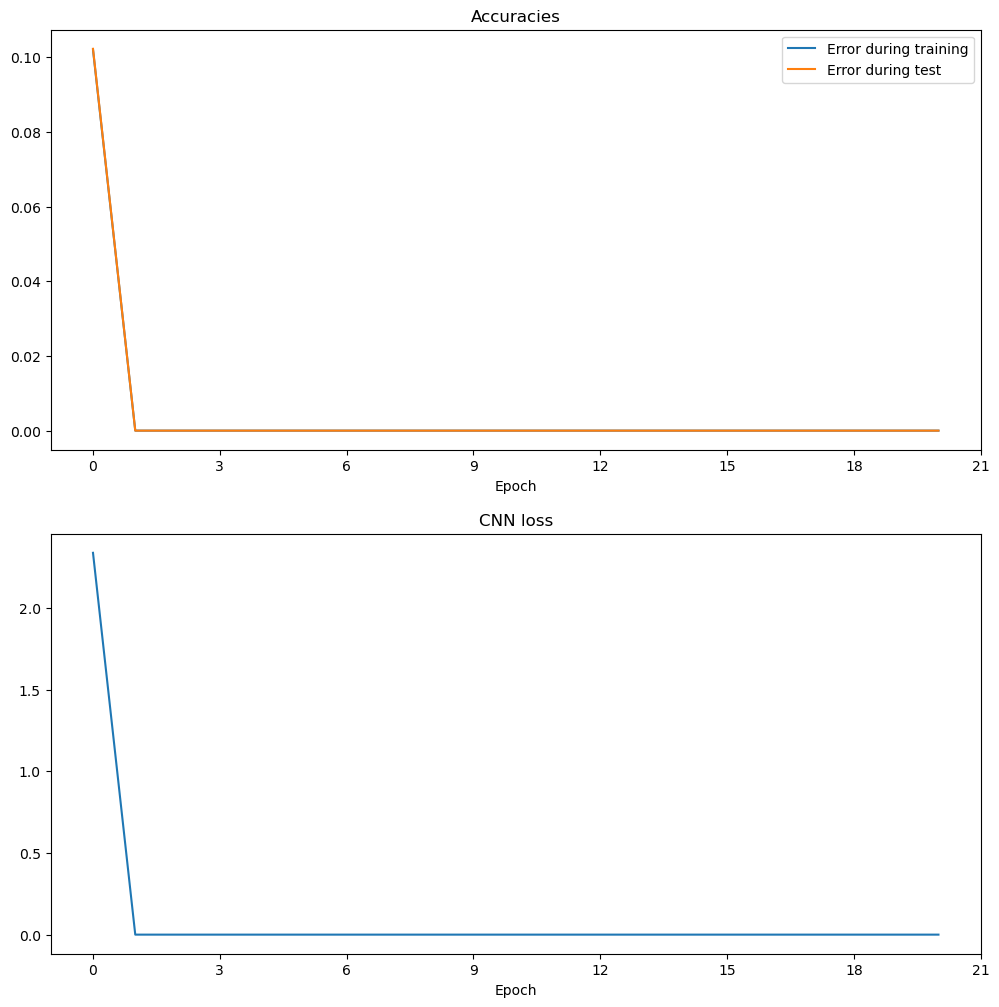

In [25]:
# Plots of accuracy and of loss function, images generated from your reference sample.
epochs = np.arange(n_epoch_cnn+1)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))

ax1.plot(epochs, accuracies_train_cnn, label = "Error during training")
ax1.plot(epochs, accuracies_test_cnn, label = "Error during test")
ax1.set_title('Accuracies')
ax1.set_xlabel('Epoch')
ax1.legend()

ax2.plot(epochs, losses_train_cnn)
ax2.set_title('CNN loss')
ax2.set_xlabel('Epoch')


for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

#plt.savefig("../figures/CNN_Metrics.png")


## Train CNN on reduced data set

In [26]:
cnn_red = CNN(n_classes).to(device=device)

In [27]:
# Loss function for the CNN
loss_function_cnn = nn.CrossEntropyLoss()

In [28]:
# Adam optimization parameters
lr_cnn = 0.001
betas_cnn = (0.9, 0.999)

optimizer_cnn = torch.optim.Adam(cnn_red.parameters(), lr=lr_cnn, betas = betas_cnn)

In [29]:
%%time

# Error metrics at initialisation

losses_train_cnn     = np.zeros(n_epoch_cnn+1)
accuracies_train_cnn = np.zeros(n_epoch_cnn+1)
accuracies_test_cnn  = np.zeros(n_epoch_cnn+1)

cnn_red.eval()
for batch_id, (real, labels) in enumerate(train_loader):
    real = real.to(device)
    labels = labels.to(device)

    pred = cnn_red(real)

    labels_pred, labels_prob, _ = cnn_red.predictLabels(pred)

    target_prob = torch.zeros_like(labels_prob)
    for i,j in enumerate(labels):
        target_prob[i][j] = 1
    target_prob = target_prob.to(device)

    loss_cnn = loss_function_cnn(labels_prob, target_prob)

    losses_train_cnn[0] += loss_cnn.item()
    accuracies_train_cnn[0] += computeCNNAccuracy(labels_pred, labels)

accuracies_train_cnn[0] /= n_batches_train
losses_train_cnn[0] /= n_batches_train

cnn_red.eval()
for batch_id, (real, labels) in enumerate(test_loader):
    real = real.to(device)
    labels = labels.to(device)
    pred = cnn_red(real)

    labels_pred, _, _ = cnn_red.predictLabels(pred)

    accuracies_test_cnn[0] += computeCNNAccuracy(labels_pred, labels)

accuracies_test_cnn[0] /= n_batches_test

print(f"Accuracy during training: {accuracies_train_cnn[0]*100:.2f}%")
print(f"Accuracy during test:     {accuracies_test_cnn[0]*100:.2f}%")
print(f"Loss during training:     {losses_train_cnn[0]:.2f}")

Accuracy during training: 11.34%
Accuracy during test:     10.29%
Loss during training:     2.31
CPU times: user 11.5 s, sys: 5.56 ms, total: 11.5 s
Wall time: 11.4 s


In [30]:
%%time
# Training of the CNN
for epoch in range(n_epoch_cnn):
    cnn_red.train()
    for batch_id, (real, labels) in enumerate(train_loader):
        real = real.to(device)
        labels = labels.to(device)

        pred = cnn_red(real)

        labels_pred, labels_prob, _ = cnn_red.predictLabels(pred)

        target_prob = torch.zeros_like(labels_prob)
        for i,j in enumerate(labels):
            target_prob[i][j] = 1
        target_prob = target_prob.to(device)
        
        loss_cnn = loss_function_cnn(labels_prob, target_prob)

        optimizer_cnn.zero_grad()
        loss_cnn.backward()
        optimizer_cnn.step()

        losses_train_cnn[epoch + 1] += loss_cnn.item()
        accuracies_train_cnn[epoch + 1] += computeCNNAccuracy(labels_pred, labels)

    accuracies_train_cnn[epoch + 1] /= n_batches_train
    losses_train_cnn[epoch + 1] /= n_batches_train

    cnn_red.eval()
    for batch_id, (real, labels) in enumerate(test_loader):
        real = real.to(device)
        labels = labels.to(device)
        pred = cnn_red(real)

        labels_pred, _, _ = cnn_red.predictLabels(pred)

        accuracies_test_cnn[epoch + 1] += computeCNNAccuracy(labels_pred, labels)

    accuracies_test_cnn[epoch + 1] /= n_batches_test

    print(f"Epoch [{epoch + 1:2d}/{n_epoch_cnn:2d}] \
            Accuracy: {accuracies_test_cnn[epoch + 1]:.4f}")

Epoch [ 1/20]             Accuracy: 0.8757
Epoch [ 2/20]             Accuracy: 0.8843
Epoch [ 3/20]             Accuracy: 0.8914


KeyboardInterrupt: 

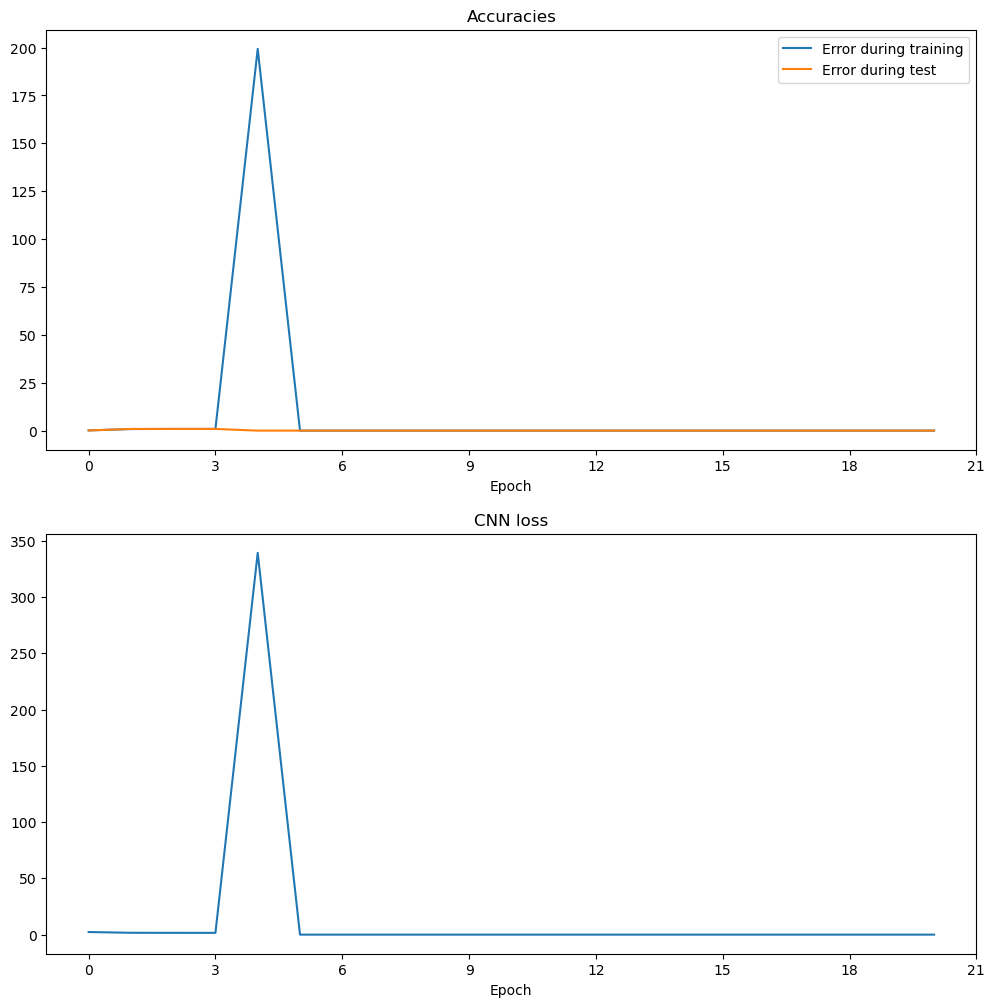

In [31]:
# Plots of accuracy and of loss function, images generated from your reference sample.
epochs = np.arange(n_epoch_cnn+1)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))

ax1.plot(epochs, accuracies_train_cnn, label = "Error during training")
ax1.plot(epochs, accuracies_test_cnn, label = "Error during test")
ax1.set_title('Accuracies')
ax1.set_xlabel('Epoch')
ax1.legend()

ax2.plot(epochs, losses_train_cnn)
ax2.set_title('CNN loss')
ax2.set_xlabel('Epoch')


for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

#plt.savefig("../figures/CNN_Metrics.png")
